In [218]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

1) Input the positional information for the platform, $b_i$, $p_i$, s, a, $\beta_i$. These are all constants from the build of the platform.
2) Input the constants for the servo motors, $W^0_i$ and r
3) Calculate the values of from equation (10), and from equation (12)
4) Input the variables for (x, y, z, ψ, θ, φ) for the required platform position
5) Calculate the rotational matrix from equation (1)
6) Calculate the effective leg lengths from equations (3)
7) Calculate the angles required for each servo from equation (9)
8) Calculate the pulse widths required for each servo from equations (13) & (14)
9) Output the values of to the μM-PWM to drive the servos
10) Return to step 4) to repeat the process.

Step 1

arm/leg connection  
![base-arm.PNG](https://raw.githubusercontent.com/nzge/stewart-platform/main/stewart-measure/base-arm.PNG)  
servo rotation  
![base-servo.PNG](https://raw.githubusercontent.com/nzge/stewart-platform/main/stewart-measure/base-servo.PNG)  
platform  
![platform-2.PNG](https://raw.githubusercontent.com/nzge/stewart-platform/main/stewart-measure/platform.PNG)  

Base points (Bi):
B1: [-39.99730632  68.01048072   0.        ]
B2: [39.99730632 68.01048072  0.        ]
B3: [78.9  0.   0. ]
B4: [ 39.99730632 -68.01048072   0.        ]
B5: [-39.99730632 -68.01048072   0.        ]
B6: [-7.89000000e+01  9.66246325e-15  0.00000000e+00]
Platform points (Pi):
P1: [-10.04733581  54.36943206   0.        ]
P2: [11.00414002 54.18388139  0.        ]
P3: [ 52.42362181 -17.5712258    0.        ]
P4: [ 41.42893883 -36.61457534   0.        ]
P5: [-41.42893883 -36.61457534   0.        ]
P6: [-52.42668777 -17.56207589   0.        ]


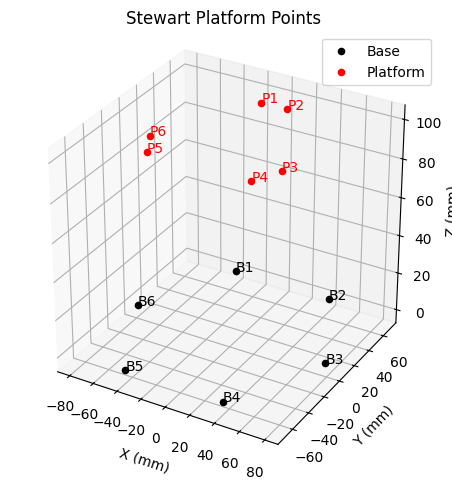

In [219]:
#mm
arm = 30 # length of the servo operating arm
s = 110 # length of the leg
a = 30 # length of the servo arm
# arm/leg joint radius: 68.74 mm 

# points of rotation of servo arms
βi = [120.46, 59.54, 0, -59.54, -120.46, 180] # angle of servo arm plane relative to the x-axis. 
b = 78.90
Bi = [b * np.array([np.cos(np.radians(β)), np.sin(np.radians(β)), 0]) for β in βi]

# platform
p = 55.29
pθ = [100.47, 78.52, -18.53, -41.47, -138.53, -161.48]
Pi = [p * np.array([np.cos(np.radians(θ)), np.sin(np.radians(θ)), 0]) for θ in pθ]

print("Base points (Bi):")
for i, point in enumerate(Bi):
    print(f"B{i+1}: {point}")
print("Platform points (Pi):")
for i, point in enumerate(Pi):
    print(f"P{i+1}: {point}")

# Plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot base points (black)
for i, point in enumerate(Bi):
    ax.scatter(*point, c='black', label='Base' if i == 0 else "")
    ax.text(*point, f'B{i+1}', color='black')

# Plot platform points (red)
for i, point in enumerate(Pi):
    elevated_point = point + np.array([0, 0, 100])  # temporary offset
    ax.scatter(*elevated_point, c='red', label='Platform' if i == 0 else "")
    ax.text(*elevated_point, f'P{i+1}', color='red')

# Axis labels and styling
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title("Stewart Platform Points")
ax.legend()
ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()

Step 2

In [220]:
# Servo Motor Constants
Wi_0 = np.array([0, 0, 0, 0, 0, 0]) # pulse widths
r =  np.array([0, 0, 0]) # pulse width change

Step 3

In [224]:
#mm
results = []

# Loop over each leg (i.e., each pair of Pi and Bi)
for i in range(6):
    xp, yp, zp = Pi[i]
    xb, yb, _ = Bi[i]
    
    # Calculate h0, L0, M0, N0, and α0 for each leg
    h0 = np.sqrt(s**2 + a**2 - (xp - xb)**2 - (yp - yb)**2 - zp)
    L0 = 2 * a**2
    M0 = 2 * a * (xp - xb)
    N0 = 2 * a * (h0 + zp)
    α0 = np.arcsin(L0 / np.sqrt(M0**2 + N0**2)) - np.arctan(M0 / N0)
    
    # Store result for the current leg
    results.append({
        "leg": i + 1,
        "h0": h0,
        "L0": L0,
        "M0": M0,
        "N0": N0,
        "α0": α0
    })

# Print or process the results for all 6 legs
for result in results:
    print(f"Leg {result['leg']}: h0 = {result['h0']}, L0 = {result['L0']}, M0 = {result['M0']}, N0 = {result['N0']}, α0 = {result['α0']}")


#“home” position of the platform. platform is at a h0=100mm above the base framework
#no other translational or rotational movement.
T = np.array([0,0, h0])
R_B = np.identity(3)
q0 = []
for i in range(6):
    q0.append(T + np.dot(R_B , Pi[i]))

Leg 1: h0 = 109.16465114050523, L0 = 1800, M0 = 1796.9982300607066, N0 = 6549.879068430314, α0 = 0.00045832277993884674
Leg 2: h0 = 109.39936681377448, L0 = 1800, M0 = -1739.5899776336971, N0 = 6563.962008826468, α0 = 0.5273460000201629
Leg 3: h0 = 109.50001562423675, L0 = 1800, M0 = -1588.5826913657452, N0 = 6570.000937454205, α0 = 0.5067909982666052
Leg 4: h0 = 109.60039942503526, L0 = 1800, M0 = 85.89795068250254, N0 = 6576.023965502116, α0 = 0.26417449411899874
Leg 5: h0 = 109.60039942503526, L0 = 1800, M0 = -85.89795068250382, N0 = 6576.023965502116, α0 = 0.29029759410475137
Leg 6: h0 = 109.5022247720699, L0 = 1800, M0 = 1588.3987338277877, N0 = 6570.133486324194, α0 = 0.032338579697583136


Step 4

In [ ]:
# Platform Position #mm
x = 0
y = 0
z = -40
ψ = 0
θ = 0
φ = 0

Step 5

In [ ]:
# Rotation Matrix

R_z = np.array([
    [np.cos(φ), -np.sin(φ), 0],
    [np.sin(φ),  np.cos(φ), 0],
    [0, 0, 1] ])
R_y = np.array([
    [np.cos(θ), 0, np.sin(θ)],
    [0, 1, 0],
    [-np.sin(θ), 0, np.cos(θ)]])
R_x = np.array([
    [1, 0, 0],
    [0,  np.cos(ψ), -np.sin(ψ)],
    [0, np.sin(ψ), np.cos(ψ)]])

R_p = R_z @ R_y @ R_x
print(R_p)

# Translation Vector
T = np.array([0,0, h0]) + np.array([x, y, z])
print(T)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[  0.           0.         119.50222477]
[array([-10.04733581,  54.36943206,   0.        ]), array([11.00414002, 54.18388139,  0.        ]), array([ 52.42362181, -17.5712258 ,   0.        ]), array([ 41.42893883, -36.61457534,   0.        ]), array([-41.42893883, -36.61457534,   0.        ]), array([-52.42668777, -17.56207589,   0.        ])]
[array([-39.99730632,  68.01048072,   0.        ]), array([39.99730632, 68.01048072,  0.        ]), array([78.9,  0. ,  0. ]), array([ 39.99730632, -68.01048072,   0.        ]), array([-39.99730632, -68.01048072,   0.        ]), array([-7.89000000e+01,  9.66246325e-15,  0.00000000e+00])]


Step 6

In [ ]:
li = []
for i in range(6):
    li.append(T + np.dot(R_p, Pi[i]) - Bi[i])
    print(f"Leg {i+1} length: {li[i]}")

Leg 1 length: [ 29.9499705  -13.64104865 119.50222477]
Leg 2 length: [-28.99316629 -13.82659933 119.50222477]
Leg 3 length: [-26.47637819 -17.5712258  119.50222477]
Leg 4 length: [  1.43163251  31.39590537 119.50222477]
Leg 5 length: [ -1.43163251  31.39590537 119.50222477]
Leg 6 length: [ 26.47331223 -17.56207589 119.50222477]


Step 7

In [ ]:
results = []
αi=[]
for i in range(6):    
    # Calculate L, M, N, and α for each leg
    L = np.linalg.norm(li[i])**2 - (s**2 - a**2)
    l_x, l_y, l_z = li[i]
    M = 2 * a * l_z
    N = 2 * a * (np.cos(np.radians(βi[i])) * l_x + np.sin(np.radians(βi[i])) * l_y)
    α = np.arcsin(L / np.sqrt(M**2 + N**2)) - np.arctan(M / N)

    αi.append(α)
    
    # Store result for the current leg
    results.append({
        "leg": i + 1,
        "L": L,
        "M": M,
        "N": N,
        "α": α
    })

# Print or process the results for all 6 legs
for result in results:
    print(f"Leg {result['leg']}: α = {np.degrees(result['α']):.2f}°")

print(αi)

Leg 1: α = 111.80°
Leg 2: α = 111.49°
Leg 3: α = 111.36°
Leg 4: α = 111.22°
Leg 5: α = 111.22°
Leg 6: α = 111.35°
[np.float64(1.9513174308316155), np.float64(1.9458544877746473), np.float64(1.9435184505737952), np.float64(1.9411923932897208), np.float64(1.9411923932897208), np.float64(1.9434672200415064)]


# Results

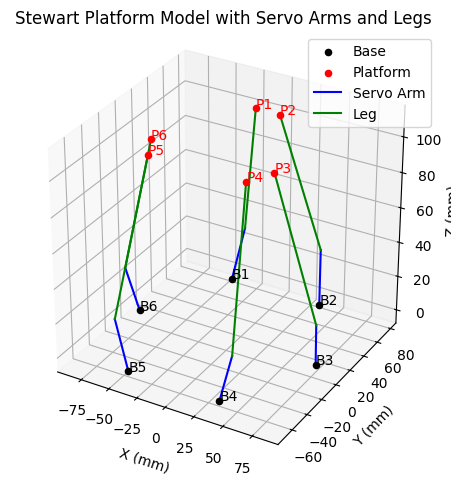

In [ ]:
# Constants

# Example servo angles αi (degrees)
#αi = [60, 15, -10, 5, -20, 10]  # Modify this to simulate different configurations

# Calculate servo arm ends (Ai) using βi and αi
Ai = []
qi = []
β = [60+180, -60, -60+180, 180, 0, 60]
for i in range(6):
    β_rad = np.radians(β[i])
    α_rad = αi[i]
    # Servo arm direction is in the servo arm plane (βi), angle αi from the radial direction
    direction = np.array([
        np.cos(β_rad) * np.cos(α_rad),
        np.sin(β_rad) * np.cos(α_rad),
        np.sin(α_rad)
    ])
    Ai.append(Bi[i] + a * direction)

    qi.append(T + np.dot(R_B , Pi[i]))


# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Base points
for i, point in enumerate(Bi):
    ax.scatter(*point, c='black', label='Base' if i == 0 else "")
    ax.text(*point, f'B{i+1}', color='black')

# Platform points
for i, point in enumerate(qi):
    ax.scatter(*point, c='red', label='Platform' if i == 0 else "")
    ax.text(*point, f'P{i+1}', color='red')

# Servo arms (Bi to Ai)
for i in range(6):
    ax.plot([Bi[i][0], Ai[i][0]], [Bi[i][1], Ai[i][1]], [Bi[i][2], Ai[i][2]],
            c='blue', label='Servo Arm' if i == 0 else "")

# Legs (Ai to Pi)
for i in range(6):
    ax.plot([Ai[i][0], qi[i][0]], [Ai[i][1], qi[i][1]], [Ai[i][2], qi[i][2]],
            c='green', label='Leg' if i == 0 else "")

# Styling
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title("Stewart Platform Model with Servo Arms and Legs")
ax.legend()
ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()

In [ ]:
# Servo arm ends (Ai)
Ai = []
for i in range(6):
    β_rad = np.radians(β[i])
    α_rad = αi[i]
    # Servo arm direction is in the servo arm plane (βi), angle αi from the radial direction
    direction = np.array([
        np.cos(β_rad) * np.cos(α_rad),
        np.sin(β_rad) * np.cos(α_rad),
        np.sin(α_rad)
    ])
    Ai.append(Bi[i] + a * direction)

# Create plotly 3D figure
fig = go.Figure()

# Plot base points
for i, point in enumerate(Bi):
    fig.add_trace(go.Scatter3d(
        x=[point[0]], y=[point[1]], z=[point[2]],
        mode='markers+text',
        text=[f'B{i+1}'],
        textposition='top center',
        marker=dict(color='black', size=5),
        name='Base' if i == 0 else '',
        showlegend=(i == 0)
    ))

# Plot platform points
for i, point in enumerate(qi):
    fig.add_trace(go.Scatter3d(
        x=[point[0]], y=[point[1]], z=[point[2]],
        mode='markers+text',
        text=[f'P{i+1}'],
        textposition='top center',
        marker=dict(color='red', size=5),
        name='Platform' if i == 0 else '',
        showlegend=(i == 0)
    ))

# Plot servo arms (Bi to Ai)
for i in range(6):
    fig.add_trace(go.Scatter3d(
        x=[Bi[i][0], Ai[i][0]],
        y=[Bi[i][1], Ai[i][1]],
        z=[Bi[i][2], Ai[i][2]],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Servo Arm' if i == 0 else '',
        showlegend=(i == 0)
    ))

# Plot legs (Ai to Pi)
for i in range(6):
    fig.add_trace(go.Scatter3d(
        x=[Ai[i][0], qi[i][0]],
        y=[Ai[i][1], qi[i][1]],
        z=[Ai[i][2], qi[i][2]],
        mode='lines',
        line=dict(color='green', width=4),
        name='Leg' if i == 0 else '',
        showlegend=(i == 0)
    ))

# Set layout
fig.update_layout(
    scene=dict(
        xaxis_title='X (mm)',
        yaxis_title='Y (mm)',
        zaxis_title='Z (mm)',
        aspectmode='data'
    ),
    title="Interactive Stewart Platform Model",
    legend=dict(itemsizing='constant')
)

fig.show()